In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../static/Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis¶

In [9]:
# Find the datatable that has date. 
measurement_row = session.query(Measurement).first()
station_row = session.query(Station).first()

# Looking at Measurement
measurement_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x149c530a130>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [10]:
# Looking at Station
station_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x149c53170d0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [11]:
# Measurement table has the dates, which order are the dates listed?
# session.query(Measurement.date).all()

### Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [12]:
# Starting from the most recent data point in the database.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [13]:
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


### Query, Order, and Clean Date and Precipitation Values.

In [14]:
# Perform a query to retrieve the date and precipitation scores.
# Sorted by date and rows with no measurements are removed.
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).\
    filter(Measurement.prcp >= 0.0).all()
#prcp

### Create DataFrame from the Tables

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(prcp, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.head(10)
#precipitation_df.count()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


### Plot DataFrame

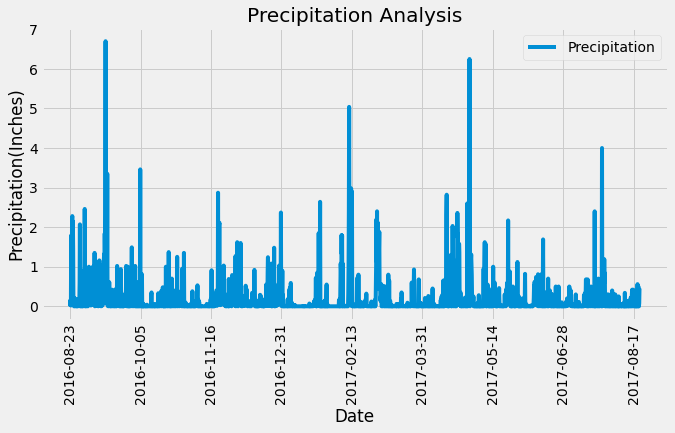

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation Analysis", ylabel="Precipitation(Inches)",  figsize=(10,5), rot=90)
# plt.savefig("precipitation_analysis.png")
plt.show()

### Summary Statistics 

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Table names for quick reference.
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [19]:
# Column names, quick reference (station).
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


In [20]:
# Column names, quick reference (measurement).
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


### Total number of Stations

In [21]:
# Query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
stations

9

In [22]:
# Confirm in Measurement Table
stations = session.query(Measurement.station).group_by(Measurement.station).count()
stations

9

### Station Numbers

In [23]:
# List all 9 stations
station_list = session.query(Measurement.station).group_by(Measurement.station).all()
station_list

[('USC00511918',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00516128',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519281',),
 ('USC00519397',),
 ('USC00519523',)]

### Station Activity (Descending)

In [24]:
# Design a query to find the most active stations 
# (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Single out that station as a variable
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active_station

('USC00519281',)

## Most Active Station: USC00519281

### Minimum Temperature(F) Measured by This Station

In [26]:
# Using the most active station id from the previous query, (my data: USC00519281)
# calculate the lowest, highest, and average temperature.
most_active_station_min = session.query(Measurement.station, Measurement.date, func.min(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active_station_min

('USC00519281', '2013-01-16', 54.0)

### Maximum Temperature(F) Measured by This Station

In [27]:
most_active_station_max = session.query(Measurement.station, Measurement.date, func.max(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active_station_max

('USC00519281', '2015-09-10', 85.0)

### Average Temperature(F) Measured by This Station

In [28]:
session.query(Measurement.station, func.avg(Measurement.tobs)).all()
most_active_station_avg = session.query(Measurement.station, Measurement.date, func.avg(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active_station_avg

('USC00519281', '2010-01-01', 71.66378066378067)

## Average Temperature Measured by Station USC00519281 From 08-23-2016 To 08-23-2017

In [35]:
# Using the most active station id (my data: USC00519281)
# Query the last 12 months of temperature observation data for this station. 


temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == most_active_station[0]).\
    order_by(Measurement.date).all()
temp_data
temp_data_df = pd.DataFrame(temp_data, columns=['Date', 'Temperature(F)'])
temp_data_df

,Date,Temperature(F)
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


## Histogram of Queried Temperature Data

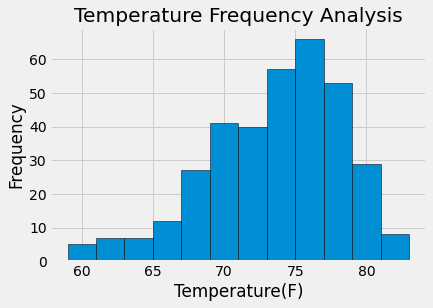

In [36]:
# Plot as a histogram
plt.hist(temp_data_df['Temperature(F)'],bins=12,ec='black')

# Give it some titles.  
plt.title("Temperature Frequency Analysis")
plt.xlabel("Temperature(F)")
plt.ylabel("Frequency")
# plt.savefig("temperature_frequency_analysis.png")
plt.show()

### Close Session

In [37]:
# Close Session
session.close()